In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from pymanticore.swift_analysis import HBTData, SOAPData
from stacking_backend import ClusterAnalysisPipeline, BasicPlotter, SummaryPlotter, MassScalingPlotter
from stacking_backend.data import load_pr4_data, PatchExtractor
from pymanticore.cosmology import ra_dec_to_galactic
import h5py

# Initialize the analysis pipeline
pipeline = ClusterAnalysisPipeline()

# Create plotters
basic_plotter = BasicPlotter(pipeline.patch_extractor)
summary_plotter = SummaryPlotter()
mass_plotter = MassScalingPlotter()

🔍 LOADING PR4 NILC Y-MAP AND MASKS
Y-map columns: ('FULL', 'HALF-RING 1', 'HALF-RING 2')
NSIDE: 2048
Coordinate system: GALACTIC
Ordering: RING
Mask columns: ('NILC-MASK', 'GAL-MASK', 'PS-MASK')



📊 Example 1: Coma Cluster


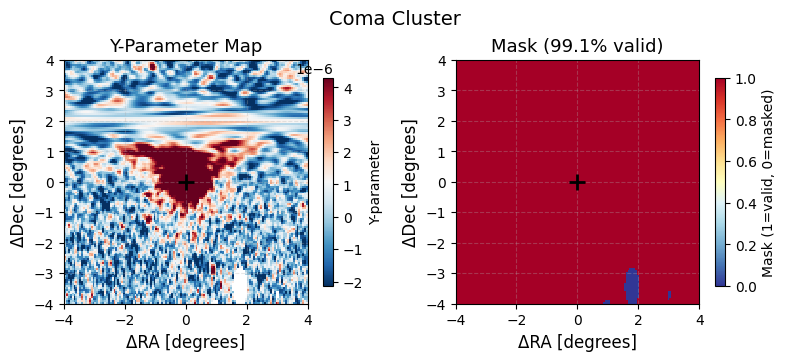

Patch shape: (128, 128)

📊 Example 2: Virgo Cluster


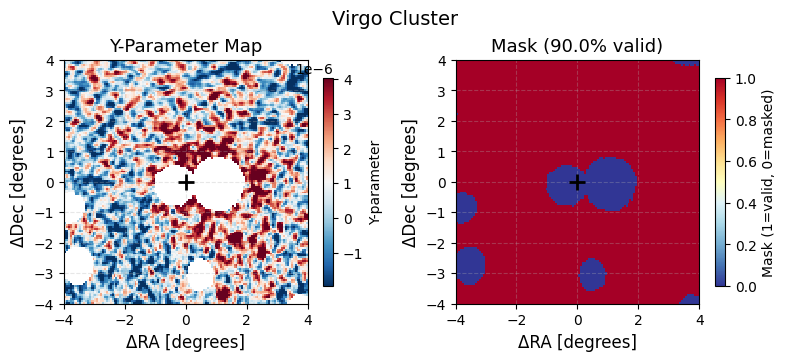

Patch shape: (128, 128)

📊 Example 3: Perseus Cluster


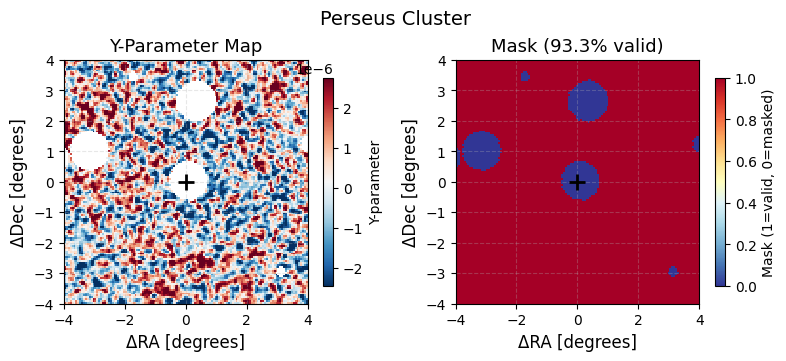

Patch shape: (128, 128)

📊 Example 4: Random Position


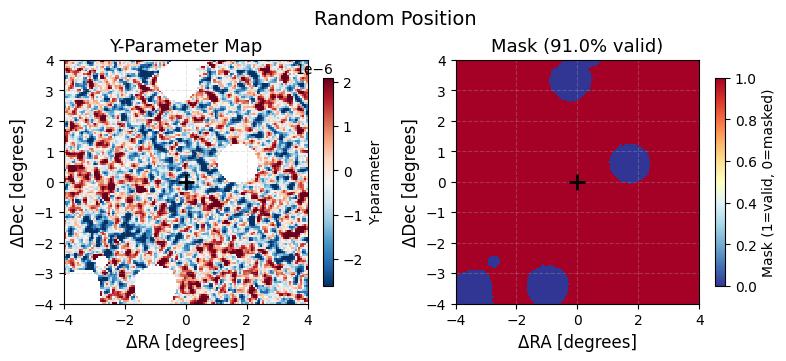

Patch shape: (128, 128)

📊 Example 5: test


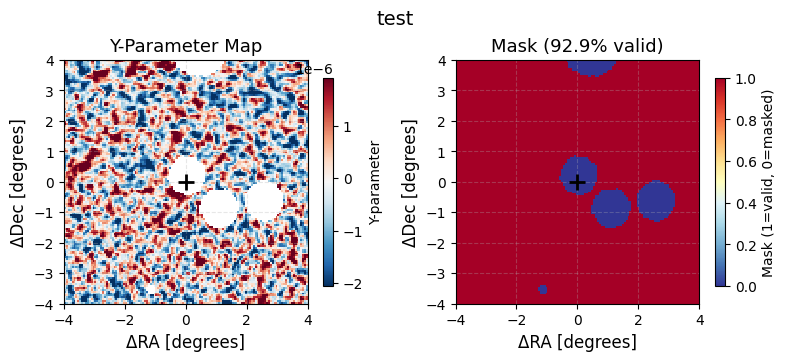

Patch shape: (128, 128)


In [2]:
# Example coordinates to plot
examples = [
    {'ra': 194.95, 'dec': 27.98, 'title': 'Coma Cluster'},
    {'ra': 186.69, 'dec': 12.83, 'title': 'Virgo Cluster'},
    {'ra': 23.40, 'dec': 30.66, 'title': 'Perseus Cluster'},
    {'ra': 120.0, 'dec': 0.0, 'title': 'Random Position'},
    {'ra': 168.1, 'dec':  40.45, 'title': "test"}
]

for i, example in enumerate(examples):
    print(f"\n📊 Example {i+1}: {example['title']}")
    
    fig, (ax1, ax2), patch_data, mask_patch = basic_plotter.plot_patch(
        ra=example['ra'],
        dec=example['dec'],
        patch_size_deg=8.0,
        npix=128,
        title=example['title'],
        show_center=True,
        show_grid=True
    )
    
    print(f"Patch shape: {patch_data.shape}")

### Load MCXC cluster catalog

In [3]:
fname = "/cosma7/data/dp004/rttw52/Manticore/observational_data/mcxc_2_clusters/mcxc_clusters.hdf5"

with h5py.File(fname, "r") as f:
    _mcxc_data = f["all_clusters"][...]

#print(_mcxc_data.dtype)
gal_l, gal_b = ra_dec_to_galactic(np.degrees(_mcxc_data["phi"]), np.degrees(_mcxc_data["theta"]))
mcxc_data = {"gal_l": gal_l, "gal_b": gal_b, "z": _mcxc_data["z"], "m500": _mcxc_data["M500"]*1e14, "r500": _mcxc_data["R500"]}

### Load eROSITA cluster catalog

In [4]:
fname = "/cosma7/data/dp004/rttw52/Manticore/observational_data/erosita_clusters/erosita_clusters.hdf5"

with h5py.File(fname, "r") as f:
    _eros_data = f["all_clusters"][...]

#print(_mcxc_data.dtype)
gal_l, gal_b = ra_dec_to_galactic(np.degrees(_eros_data["phi"]), np.degrees(_eros_data["theta"]))
eros_data = {"gal_l": gal_l, "gal_b": gal_b, "z": _eros_data["z"], "m500": _eros_data["M500"]*1e14, "r500": _eros_data["R500"]}

## Load Manticore posterior clusters

In [5]:
import numpy as np
import h5py
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

fname = "/cosma7/data/dp004/rttw52/Manticore/new_analysis/clusters/temp/output/simplified_clusters.h5"

with h5py.File(fname, "r") as f:
    distances_mpc = f["clusters/median_properties/dist"][...]
    
    # Convert comoving distance to redshift using Planck18 cosmology
    redshifts = []
    for dist in distances_mpc:
        z = z_at_value(Planck18.comoving_distance, dist * u.Mpc)
        redshifts.append(z)
    
    manticore_data = {"gal_l": f["clusters/median_properties/gal_l"][...],
                      "gal_b": f["clusters/median_properties/gal_b"][...],
                      "m500": f["clusters/median_properties/SO_500_crit_TotalMass"][...],
                      "r500": f["clusters/median_properties/SO_500_crit_SORadius"][...],
                      "dist": distances_mpc,
                      "z": np.array(redshifts)}

In [6]:
def plot_halo_overview(halo_data, z_min=None, z_max=None, figsize=(15, 10), cat_name=""):
    """
    Plot overview of cluster data.
    
    Parameters
    ----------
    halo_data : dict
        Dictionary containing cluster data with keys: 'gal_l', 'gal_b', 'z', 'm500', 'r500'
    z_min : float, optional
        Minimum redshift to include in plots
    z_max : float, optional
        Maximum redshift to include in plots
    figsize : tuple, optional
        Figure size (width, height)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Apply redshift filter if specified
    if z_min is not None or z_max is not None:
        z_mask = np.ones(len(halo_data["z"]), dtype=bool)
        if z_min is not None:
            z_mask &= (halo_data["z"] >= z_min)
        if z_max is not None:
            z_mask &= (halo_data["z"] <= z_max)
        
        # Create filtered data
        filtered_data = {key: np.array(values)[z_mask] for key, values in halo_data.items()}
        title_suffix = f" (z: {z_min or 'min'} - {z_max or 'max'})"
    else:
        filtered_data = halo_data
        title_suffix = ""
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'{cat_name} Clusters Overview{title_suffix}', fontsize=16, fontweight='bold')

    # 1. Sky distribution in galactic coordinates
    ax1 = axes[0, 0]
    scatter = ax1.scatter(filtered_data["gal_l"], filtered_data["gal_b"], 
                         c=filtered_data["z"], cmap='viridis', alpha=0.7, s=20)
    ax1.set_xlabel('Galactic Longitude (deg)')
    ax1.set_ylabel('Galactic Latitude (deg)')
    ax1.set_title('Sky Distribution (colored by redshift)')
    ax1.set_xlim(0, 360)
    ax1.set_ylim(-90, 90)
    plt.colorbar(scatter, ax=ax1, label='Redshift')

    # 2. Redshift distribution
    ax2 = axes[0, 1]
    ax2.hist(filtered_data["z"], bins=30, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Redshift')
    ax2.set_ylabel('Number of Clusters')
    ax2.set_title('Redshift Distribution')
    ax2.axvline(np.median(filtered_data["z"]), color='red', linestyle='--', 
               label=f'Median: {np.median(filtered_data["z"]):.3f}')
    ax2.legend()

    # 3. Mass distribution
    ax3 = axes[0, 2]
    ax3.hist(np.log10(filtered_data["m500"]), bins=30, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('log₁₀(M₅₀₀) [M☉]')
    ax3.set_ylabel('Number of Clusters')
    ax3.set_title('Mass Distribution')
    ax3.axvline(np.log10(np.median(filtered_data["m500"])), color='red', linestyle='--',
               label=f'Median: {np.median(filtered_data["m500"]):.1e} M☉')
    ax3.legend()

    # 4. R500 distribution
    ax4 = axes[1, 0]
    ax4.hist(filtered_data["r500"], bins=30, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('R₅₀₀ [Mpc]')
    ax4.set_ylabel('Number of Clusters')
    ax4.set_title('R₅₀₀ Distribution')
    ax4.axvline(np.median(filtered_data["r500"]), color='red', linestyle='--',
               label=f'Median: {np.median(filtered_data["r500"]):.2f} Mpc')
    ax4.legend()

    # 5. Mass vs Redshift
    ax5 = axes[1, 1]
    scatter2 = ax5.scatter(filtered_data["z"], np.log10(filtered_data["m500"]), 
                          c=filtered_data["r500"], cmap='plasma', alpha=0.7, s=20)
    ax5.set_xlabel('Redshift')
    ax5.set_ylabel('log₁₀(M₅₀₀) [M☉]')
    ax5.set_title('Mass vs Redshift (colored by R₅₀₀)')
    plt.colorbar(scatter2, ax=ax5, label='R₅₀₀ [Mpc]')

    # 6. Data summary statistics
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    n_total = len(halo_data["z"])
    n_filtered = len(filtered_data["z"])
    
    stats_text = f"""Data Summary:
Total Clusters: {n_total:,}
Filtered Clusters: {n_filtered:,}
Filter: z ∈ [{z_min or 'min'}, {z_max or 'max'}]

Redshift:
  Range: {np.min(filtered_data["z"]):.3f} - {np.max(filtered_data["z"]):.3f}
  Mean: {np.mean(filtered_data["z"]):.3f}
  Std: {np.std(filtered_data["z"]):.3f}

Mass (M₅₀₀):
  Range: {np.min(filtered_data["m500"]):.1e} - {np.max(filtered_data["m500"]):.1e} M☉
  Mean: {np.mean(filtered_data["m500"]):.1e} M☉
  
R₅₀₀:
  Range: {np.min(filtered_data["r500"]):.2f} - {np.max(filtered_data["r500"]):.2f} Mpc
  Mean: {np.mean(filtered_data["r500"]):.2f} Mpc

Sky Coverage:
  Gal_l: {np.min(filtered_data["gal_l"]):.1f}° - {np.max(filtered_data["gal_l"]):.1f}°
  Gal_b: {np.min(filtered_data["gal_b"]):.1f}° - {np.max(filtered_data["gal_b"]):.1f}°"""

    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

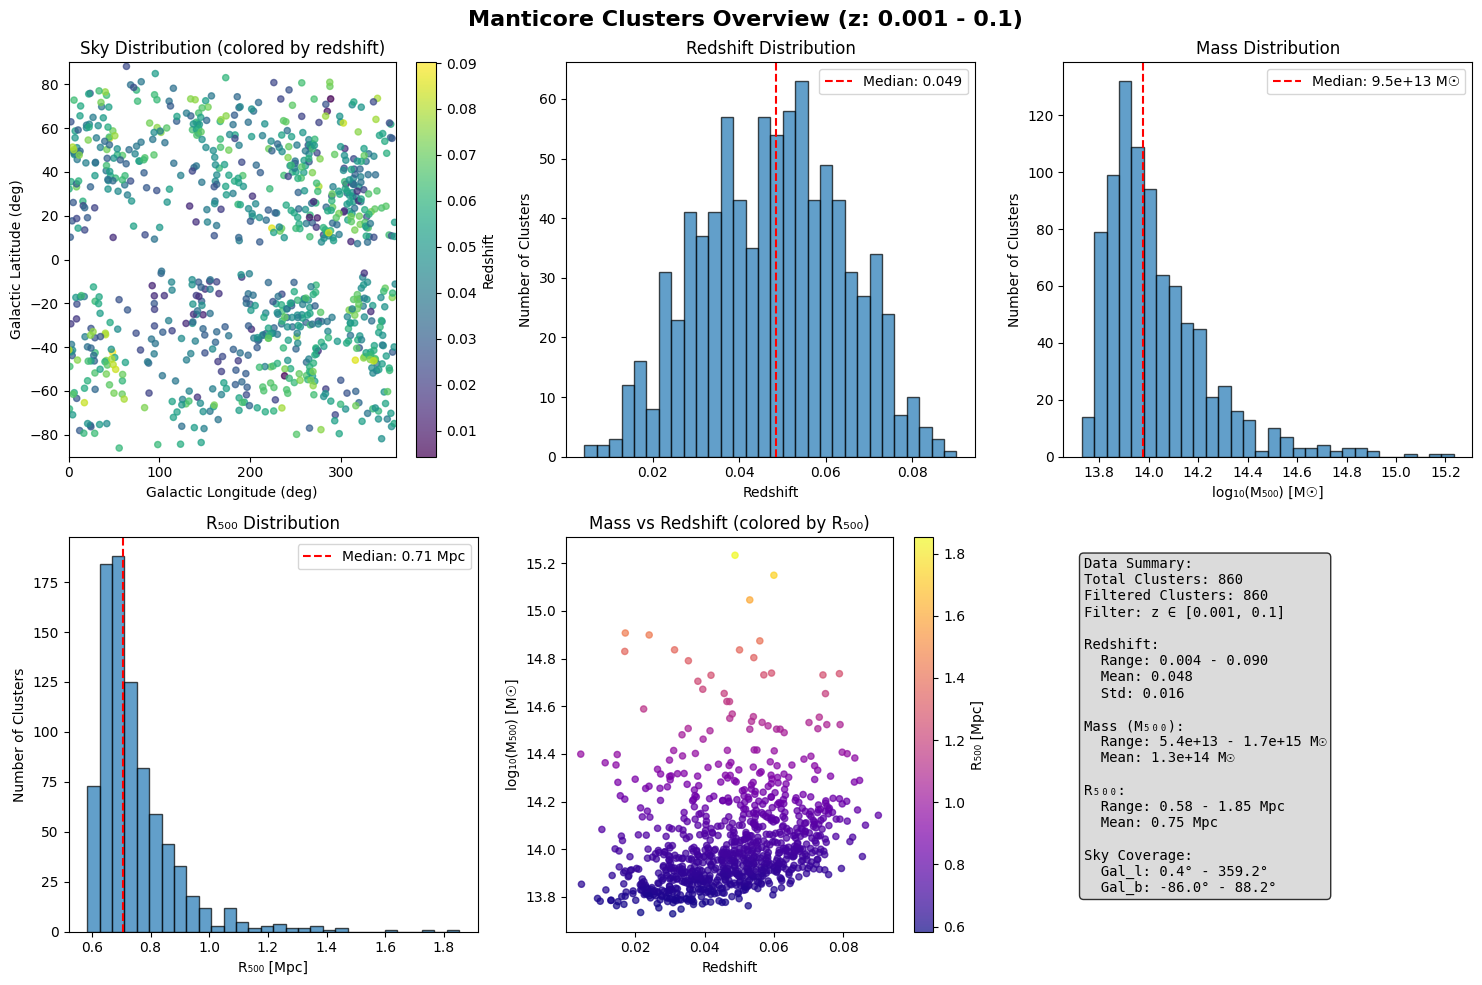

In [7]:
# plot_mcxc_overview(mcxc_data)  # Plot all data
plot_halo_overview(manticore_data, z_min=0.001, z_max=0.1, cat_name="Manticore")

In [8]:
l_min = 20
l_max = 80

def generate_random_halos(n_halos):
    """Generate random positions for null test"""
    random_halos = []
    for i in range(n_halos):
        lon = np.random.uniform(0, 360)
        lat = np.random.uniform(-l_max, l_max)
        if abs(lat) > l_min:
            r200_deg = np.random.lognormal(np.log(1.0), 0.3)
            redshift = np.random.normal(0.05, 0.02)
            random_halos.append((lon, lat, r200_deg, max(0.01, redshift)))
    return random_halos

In [9]:
mass_bins = [
    (0.6e14, 0.8e14),
    (0.8e14, 1e14),
    (1e14, 2e14),
    (2e14, 4e14),
    (4e14, 6e14),
    (6e14, 8e14),
    (8e14, 20e14),
    #(0,0),
]

inner_r200_factor=1.0
outer_r200_factor=3.0
patch_size_deg=20.0
npix=256
z_min = 0.005
z_max = 0.1
b_min = 10
b_max = 80

results_dict = {}

for i, (mass_min, mass_max) in enumerate(mass_bins):

    mass_label = f"{mass_min:.1e}-{mass_max:.1e}"
    print(f"\n📊 Mass bin {i+1}/{len(mass_bins)}: {mass_label} M☉")

    if mass_min > 0:
        #coord_list = np.array([[x[4], x[5], x[6], x[2]] for x in centers.values() if x[3] > mass_min and x[3] < mass_max and np.abs(x[5]) > l_min and np.abs(x[5]) < l_max])
        #coord_list = np.array([[row['gal_l'], row['gal_b'], row['r200'], row['z']] for row in data if row['z'] > z_min and row['z'] < z_max and np.abs(row['gal_b']) > b_min and np.abs(row['gal_b']) < b_max and row['m200'] >= mass_min and row['m200'] <= mass_max])
        #coord_list = np.array([[mcxc_data["gal_l"][i], mcxc_data["gal_b"][i], mcxc_data["r500"][i], mcxc_data["z"][i]] for i in range(len(mcxc_data["z"])) if mcxc_data['z'][i] > z_min and mcxc_data['z'][i] < z_max and np.abs(mcxc_data['gal_b'][i]) > b_min and np.abs(mcxc_data['gal_b'][i]) < b_max and mcxc_data['m500'][i] >= mass_min and mcxc_data['m500'][i] <= mass_max])
        coord_list = np.array([[eros_data["gal_l"][i], eros_data["gal_b"][i], eros_data["r500"][i], eros_data["z"][i]] for i in range(len(eros_data["z"])) if eros_data['z'][i] > z_min and eros_data['z'][i] < z_max and np.abs(eros_data['gal_b'][i]) > b_min and np.abs(eros_data['gal_b'][i]) < b_max and eros_data['m500'][i] >= mass_min and eros_data['m500'][i] <= mass_max])

        results = pipeline.run_individual_r200_analysis(
            coord_list=coord_list,
            inner_r200_factor=inner_r200_factor,
            outer_r200_factor=outer_r200_factor,
            patch_size_deg=patch_size_deg,
            npix=npix,
            min_coverage=0.8,
            n_radial_bins=30
        )
        
        # Add mass information to results
        results['mass_range'] = (mass_min, mass_max)
        results['mass_label'] = mass_label
        results['mass_center'] = np.sqrt(mass_min * mass_max)  # Geometric mean
    # Random pointings
    else:
        coord_list = generate_random_halos(100)
        results = pipeline.run_individual_r200_analysis(
            coord_list=coord_list,
            inner_r200_factor=inner_r200_factor,
            outer_r200_factor=outer_r200_factor,
            patch_size_deg=patch_size_deg,
            npix=npix,
            min_coverage=0.8,
            n_radial_bins=30
        )
        results['mass_range'] = (None, None)
        results['mass_label'] = f"random_{i}"
        results['mass_center'] = None

    if mass_min > 0:
        results_dict[mass_label] = results
    else:
        results_dict[f"random_{i}"] = results
    print(f"   ✅ Analysis complete: {results['significance']:.1f}σ from {results['n_measurements']} clusters")


📊 Mass bin 1/7: 6.0e+13-8.0e+13 M☉
🚀 CLUSTER ANALYSIS PIPELINE (Individual R200)
Input coordinates: 123
Patch parameters: 20.0° × 20.0° (256×256)
Aperture photometry: 1.0R200 inner, 3.0R200 outer
All clusters expected to have R200 data

🔍 Step 1: Individual cluster measurements...
🔍 Calculating individual cluster measurements with individual R200...
   ✅ Calculated 89 valid measurements
   ❌ Rejected: 34 clusters
      - insufficient_mask_coverage: 34

📚 Step 2: Stacking patches from valid clusters...
🔄 Stacking 89 patches...
✅ Using 70 valid patches
   Rejected: 19 (coverage), 0 (errors)
   Stack dimensions: (256, 256)
   Valid pixel range: 51-70 patches

📊 Step 3: Radial profile...
📊 Calculating radial profile...
   Radial bins: 30, Max radius: 10.0°
   Profile calculated: 30/30 valid bins

🎯 Step 4: Final statistics from individual measurements...
✅ Sample statistics:
   Mean Δy: 7.23e-08
   Sample std: 4.98e-07
   Standard error: 5.28e-08
   Significance: 1.4σ

📏 R200 statistics:


/cosma7/data/dp004/rttw52/Manticore/new_analysis/clusters/temp/stacking_backend/plotting/summary_plots.py:214: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(radii_plot, profile_plot, yerr=errors_plot,


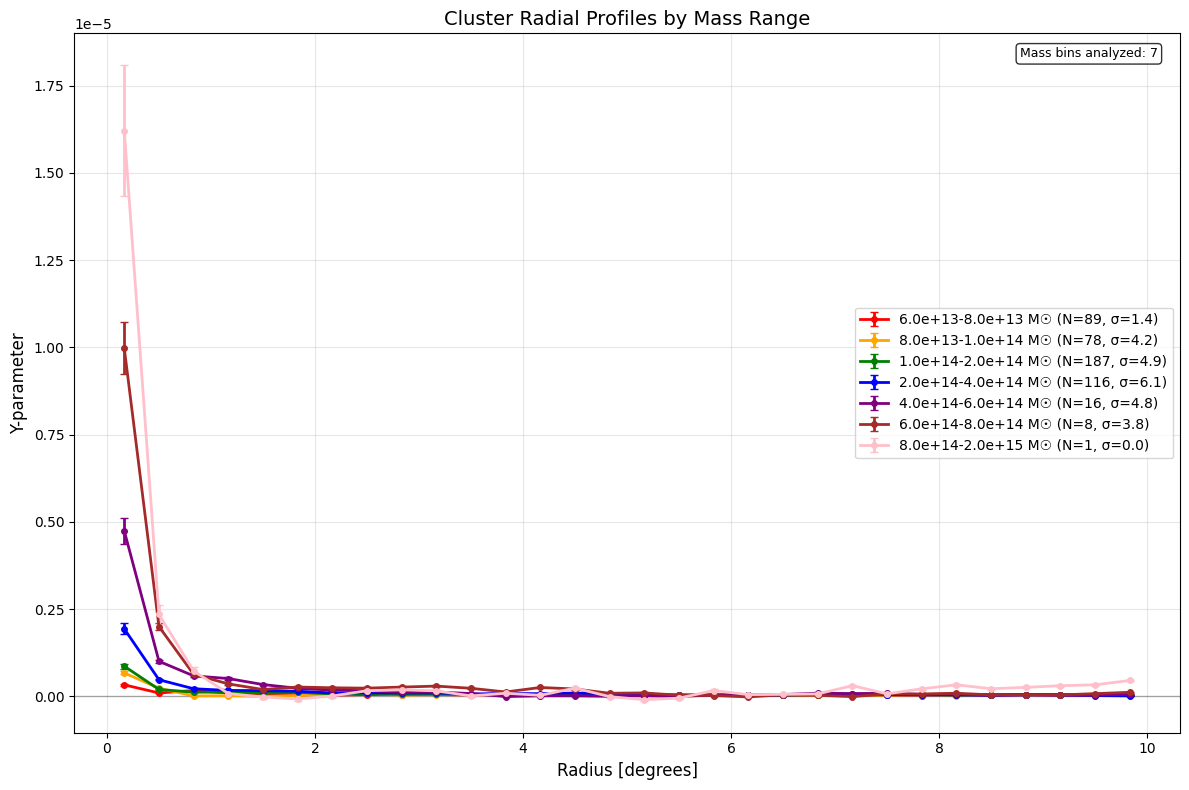

In [10]:
fig1, ax1 = summary_plotter.plot_mass_range_profiles(results_dict)

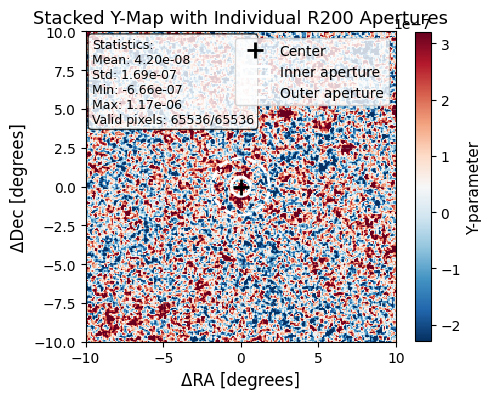

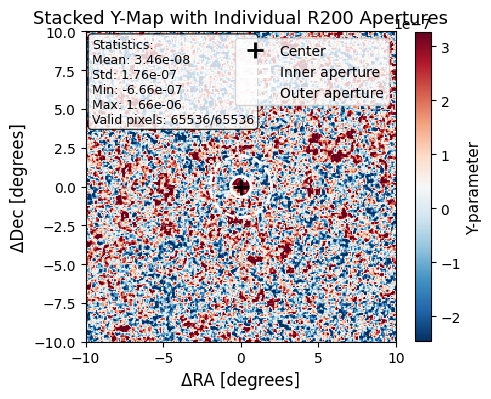

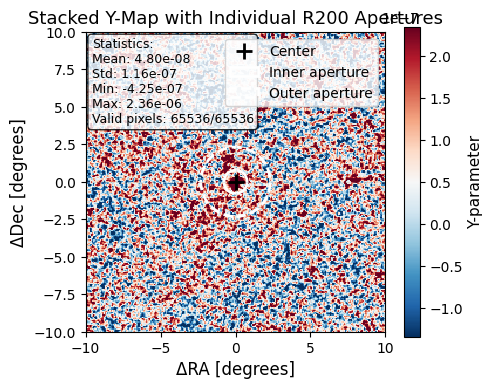

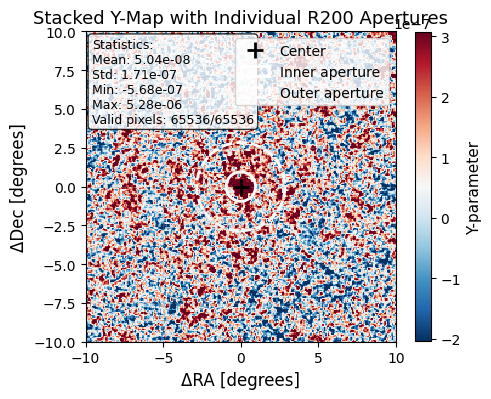

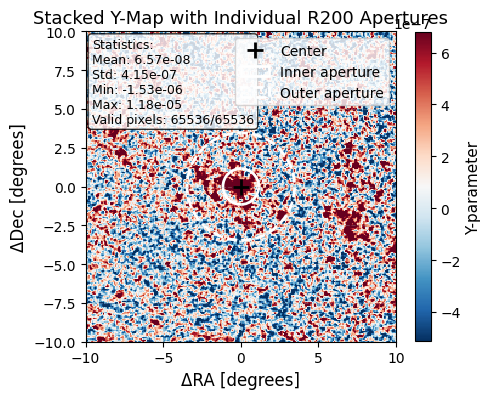

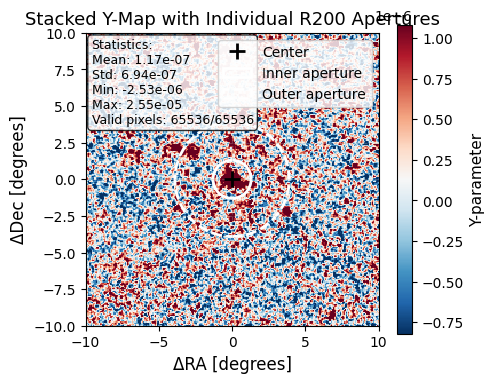

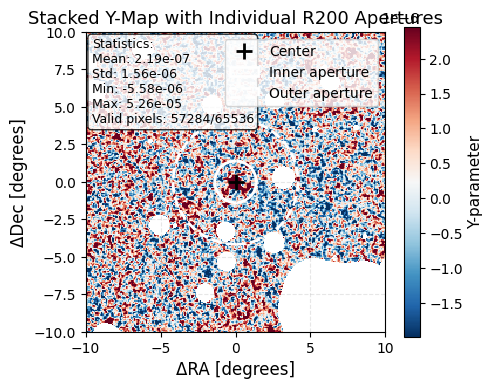

In [11]:
for mass_range, results in results_dict.items():

    inner_radius_deg = results['r200_median'] * inner_r200_factor  # inner_r200_factor
    outer_radius_deg = results['r200_median'] *  outer_r200_factor # outer_r200_factor
    
    # Or use the actual ranges if you want to show the variation
    inner_radii_range = results['inner_radii_range']  # (min, max)
    outer_radii_range = results['outer_radii_range']  # (min, max)
    
    # Plot the stacked patch
    basic_plotter.plot_stacked_patch(
        stacked_patch=results['stacked_patch'],
        patch_size_deg=results['patch_size_deg'],
        title="Stacked Y-Map with Individual R200 Apertures",
        show_apertures=True,
        inner_radius_deg=inner_radius_deg,  # Use median values
        outer_radius_deg=outer_radius_deg
    )

📊 Scaling Fit Results:
   Fitted slope: α = 1.33
   Theory slope: α = 1.79
   χ²/dof = 1.8/5 = 0.36


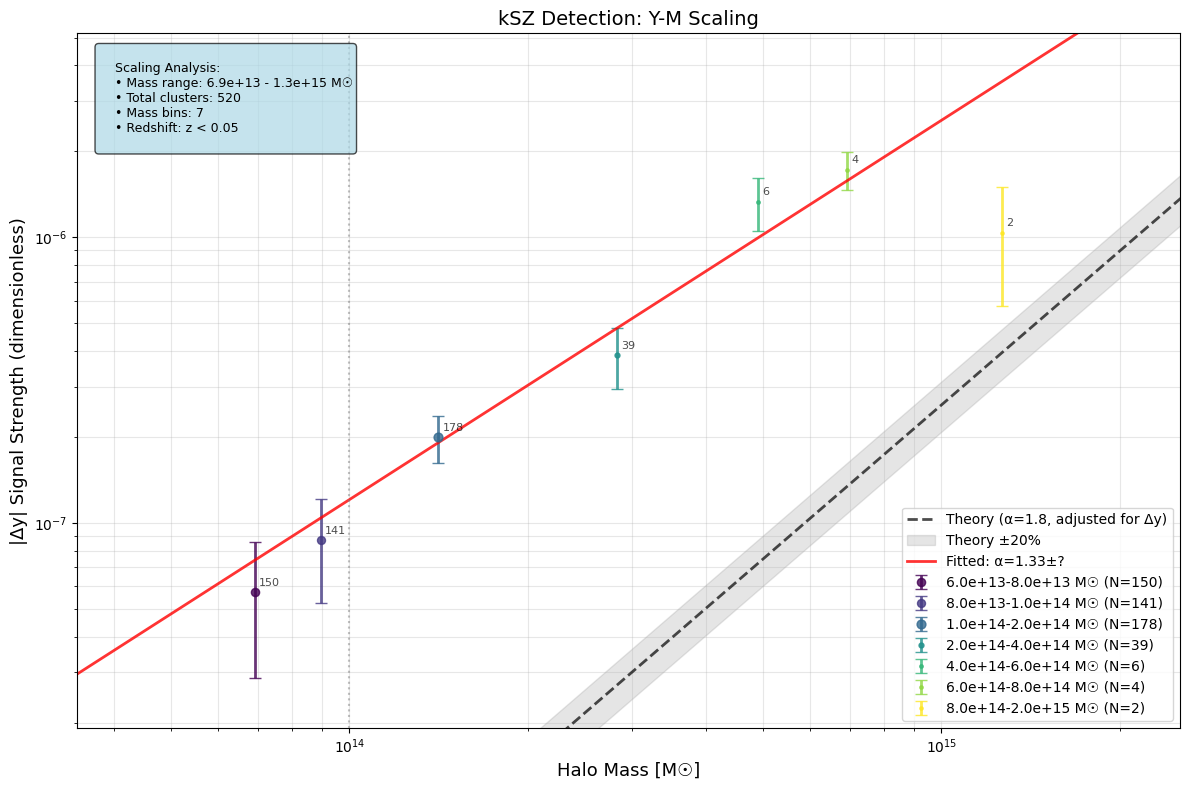

Your slope: 1.33
Theory slope: 1.79


In [30]:
fig, ax, fit_results = mass_plotter.plot_y_mass_scaling(
    results_dict, 
    title="kSZ Detection: Y-M Scaling",
    show_theory=True,
    fit_scaling=True
)

# Check fit results
if fit_results:
    print(f"Your slope: {fit_results['fitted_slope']:.2f}")
    print(f"Theory slope: {fit_results['theory_slope']:.2f}")